In [1]:
from pnet import pnet_loader, Pnet, PnetOG, ReactomeNetworkOG
from util import util, sankey_diag

import torch
import seaborn as sns
import pandas as pd
import numpy as np
import random
import pickle
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
import os
import torch.nn.functional as F
import torch.nn as nn

%load_ext autoreload
%autoreload 2

/root/miniconda3/envs/pnet/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Generate small test dataset

In [2]:
# rna_ext_val = pd.read_csv('/mnt/disks/pancan/data/mel_dfci_2019/data_RNA_Seq_expression_tpm_all_sample_Zscores.txt',
#                           delimiter='\t').set_index('Hugo_Symbol').T.drop('Entrez_Gene_Id').dropna(axis=1)
# cna_ext_val = pd.read_csv('/mnt/disks/pancan/data/mel_dfci_2019/data_CNA.txt',
#                           delimiter='\t').set_index('Hugo_Symbol').T.dropna(axis=1)
# ext_val = pd.read_csv('/mnt/disks/pancan/data/mel_dfci_2019/data_clinical_sample.txt',
#                              delimiter='\t').set_index('Sample Identifier').iloc[4:]
# important_genes = list(pd.read_csv('/mnt/disks/pancan/m1000/cancer_genes.txt')['genes'].values)
# joint_genes = list(set(important_genes).intersection(list(rna_ext_val.columns), list(cna_ext_val.columns)))
# gene_list = random.sample(joint_genes, 500)
# random_genes_a = list(rna_ext_val.sample(5, axis=1).columns)
# random_genes_b = list(cna_ext_val.sample(5, axis=1).columns)
# joint_samples = list(rna_ext_val.sample(20).join(cna_ext_val, rsuffix='_cna', how='inner').index)
# random_samples_a = list(rna_ext_val.sample(5, axis=0).index)
# random_samples_b = list(cna_ext_val.sample(5, axis=0).index)
# random_samples_c = list(cna_ext_val.sample(5, axis=0).index)
# random_samples_d = list(cna_ext_val.sample(5, axis=0).index)
# test_rna = rna_ext_val.loc[joint_samples+random_samples_a][joint_genes+random_genes_a].copy().drop_duplicates()
# test_cna = cna_ext_val.loc[joint_samples+random_samples_b][joint_genes+random_genes_b].copy().drop_duplicates()
# test_add = ext_val.loc[joint_samples+random_samples_c][['Purity', 'Ploidy']].copy().drop_duplicates()
# test_y = ext_val.loc[joint_samples+random_samples_d][['Heterogeneity']].copy().drop_duplicates()
# test_rna.reset_index(inplace=True)
# test_cna.reset_index(inplace=True)
# test_add.reset_index(inplace=True)
# test_y.reset_index(inplace=True)
# test_rna.rename(columns={'index': 'sample_id'}, inplace=True)
# test_cna.rename(columns={'index': 'sample_id'}, inplace=True)
# test_add.rename(columns={'Sample Identifier': 'sample_id'}, inplace=True)
# test_y.rename(columns={'Sample Identifier': 'sample_id'}, inplace=True)
# test_rna.to_csv('../data/test_data/rna.csv', index=False)
# test_cna.to_csv('../data/test_data/cna.csv', index=False)
# test_add.to_csv('../data/test_data/add.csv', index=False)
# test_y.to_csv('../data/test_data/y.csv', index=False)
# with open('../data/test_data/gene_sublist.txt', 'wb') as fp:
#     pickle.dump(gene_list, fp)

Read test data

In [3]:
test_rna = pd.read_csv('../data/test_data/rna.csv').set_index('sample_id')
test_cna = pd.read_csv('../data/test_data/cna.csv').set_index('sample_id')
test_add = pd.read_csv('../data/test_data/add.csv').set_index('sample_id')
test_y = pd.read_csv('../data/test_data/y.csv').set_index('sample_id')

with open('../data/test_data/gene_sublist.txt', 'rb') as fp:
    gene_list = pickle.load(fp)

In [4]:
genetic_data = {'rna': test_rna, 'cna': test_cna}

In [5]:
# First binarize the target to ensure we know the class distribution
test_y_bin = test_y.apply(lambda x: round(2*x)).astype(int)

# Use stratified split by manually selecting indices to ensure both classes in train/test
from sklearn.model_selection import train_test_split

# Get indices grouped by class
class_0_indices = test_y_bin[test_y_bin['Heterogeneity'] == 0].index.tolist()
class_1_indices = test_y_bin[test_y_bin['Heterogeneity'] == 1].index.tolist()

print(f"Class 0 samples: {len(class_0_indices)}")
print(f"Class 1 samples: {len(class_1_indices)}")

# Ensure we have at least 1 sample from each class in test set
if len(class_0_indices) >= 2 and len(class_1_indices) >= 2:
    # Take at least 1 from each class for test
    test_inds = class_0_indices[:1] + class_1_indices[:1]
    train_inds = class_0_indices[1:] + class_1_indices[1:]
    print(f"Manual split - Train: {len(train_inds)}, Test: {len(test_inds)}")
else:
    # Fall back to regular split if not enough samples
    train_inds = None
    test_inds = None
    print("Using default random split")

train_dataset, test_dataset = pnet_loader.generate_train_test(genetic_data,
                                                              test_y_bin,  # Use binarized target
                                                              additional_data=test_add,
                                                              test_split=0.2,
                                                              gene_set=gene_list,
                                                              collinear_features=2,
                                                              train_inds=train_inds,
                                                              test_inds=test_inds)

Class 0 samples: 16
Class 1 samples: 8
Manual split - Train: 22, Test: 2
Given 2 Input modalities
Found 20 overlapping indicies
Initializing Train Dataset
Found 500 overlapping genes
generated input DataFrame of size (18, 1000)
Initializing Test Dataset
Found 500 overlapping genes
generated input DataFrame of size (2, 1000)
Replace input of: MDS2_cna with collinear feature.
Replace input of: KLF4_rna with collinear feature.


In [6]:
# Debug: Let's check what's happening with the genes
print("Length of gene_list:", len(gene_list))
print("Length of train_dataset.genes:", len(train_dataset.genes))
print("Shape of train_dataset.input_df:", train_dataset.input_df.shape)
print("Number of columns in input_df:", len(train_dataset.input_df.columns))
print("\nFirst 5 genes from gene_list:", gene_list[:5])
print("First 5 genes from train_dataset.genes:", train_dataset.genes[:5])
print("First 5 columns from input_df:", list(train_dataset.input_df.columns)[:5])
print("\nLast 5 columns from input_df:", list(train_dataset.input_df.columns)[-5:])

Length of gene_list: 500
Length of train_dataset.genes: 500
Shape of train_dataset.input_df: (18, 1000)
Number of columns in input_df: 1000

First 5 genes from gene_list: ['PPFIBP1', 'NF1', 'CCDC6', 'PRDM2', 'RNF43']
First 5 genes from train_dataset.genes: ['CYP2C8', 'DICER1', 'CNBD1', 'ETNK1', 'SMARCB1']
First 5 columns from input_df: ['CYP2C8_rna', 'DICER1_rna', 'CNBD1_rna', 'ETNK1_rna', 'SMARCB1_rna']

Last 5 columns from input_df: ['ACSL6_cna', 'HERPUD1_cna', 'TMPRSS2_cna', 'FGFR4_cna', 'TRRAP_cna']


In [7]:
assert set(gene_list) == set(train_dataset.genes), 'Training dataset expected to have the same gene set as in file'

# Check that all genes from train_dataset.genes appear in the columns with appropriate suffixes
input_cols = list(train_dataset.input_df.columns)
genes_from_cols = set()
for col in input_cols:
    # Remove the modality suffix to get the gene name
    if col.endswith('_rna') or col.endswith('_cna'):
        gene = col.rsplit('_', 1)[0]
        genes_from_cols.add(gene)

assert set(train_dataset.genes) == genes_from_cols, 'Training data genes should match the genes in input_df columns'

# Since we have 2 modalities (rna and cna), we expect 1000 columns for 500 genes
# The number of rows depends on the train/test split
n_train_samples = train_dataset.input_df.shape[0]
n_test_samples = test_dataset.input_df.shape[0]
total_samples = n_train_samples + n_test_samples

print(f"Dataset split: {n_train_samples} train, {n_test_samples} test (total: {total_samples})")

assert train_dataset.input_df.shape[1] == 1000, f'Expected 1000 columns (500 genes × 2 modalities), got: {train_dataset.input_df.shape[1]}'
assert train_dataset.x.shape == torch.Size([n_train_samples, 1000]), f'Train dataset tensor shape mismatch'
assert train_dataset.y.shape == torch.Size([n_train_samples, 1]), f'Train target shape mismatch'

assert test_dataset.input_df.shape[1] == 1000, f'Expected 1000 columns in test set, got: {test_dataset.input_df.shape[1]}'
assert test_dataset.x.shape == torch.Size([n_test_samples, 1000]), f'Test dataset tensor shape mismatch'
assert test_dataset.y.shape == torch.Size([n_test_samples, 1]), f'Test target shape mismatch'

Dataset split: 18 train, 2 test (total: 20)


In [8]:
train_loader, val_loader = pnet_loader.to_dataloader(train_dataset, test_dataset, 64)

In [9]:
# test_y_bin already created in cell 6
# Check class distribution in train and test sets
print("Train set class distribution:")
print(pd.Series(train_dataset.y.numpy().flatten()).value_counts())
print("\nTest set class distribution:")
print(pd.Series(test_dataset.y.numpy().flatten()).value_counts())

Train set class distribution:
0.0    13
1.0     5
Name: count, dtype: int64

Test set class distribution:
1.0    1
0.0    1
Name: count, dtype: int64


In [10]:
# Use the existing gene_list from test data as cancer genes for testing
# Note: This is a subset of 500 cancer genes used for testing purposes
canc_genes = gene_list
print(f"Using {len(canc_genes)} cancer genes from test data for analysis")

Using 500 cancer genes from test data for analysis


Task defined: BC 
 if this is not the intended task please specify task
Given 2 Input modalities
Found 20 overlapping indicies
Initializing Train Dataset
Found 500 overlapping genes
generated input DataFrame of size (16, 1000)
Initializing Test Dataset
Found 500 overlapping genes
generated input DataFrame of size (4, 1000)
Found 500 overlapping genes


/procedure/pnet/src/pnet/ReactomeNetwork.py:197: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  gene_connections = pd.DataFrame(index=self.gene_list, columns=pathway_nodes).fillna(0)
/procedure/pnet/src/pnet/ReactomeNetwork.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pathway_connections = pd.DataFrame(index=pathway_nodes, columns=higher_level_pathway_nodes).fillna(0)
/procedure/pnet/src/pnet/ReactomeNetwork.py:204: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Curre

Epoch 1 of 10
Train Loss: 8.589550495147705
Test Loss: 20.105777740478516
Epoch 2 of 10
Train Loss: 8.810637950897217
Test Loss: 20.10953140258789
Epoch 3 of 10
Train Loss: 7.2389585971832275
Test Loss: 20.1170711517334
Epoch 4 of 10
Train Loss: 7.750210523605347
Test Loss: 20.1286678314209
Epoch 5 of 10
Train Loss: 6.834181785583496
Test Loss: 20.143604278564453
Epoch 6 of 10
Train Loss: 6.72192907333374
Test Loss: 20.163850784301758
Epoch 7 of 10
Train Loss: 6.839750051498413
Test Loss: 20.189210891723633
Epoch 8 of 10
Train Loss: 7.542793273925781
Test Loss: 20.216197967529297
Epoch 9 of 10
Train Loss: 6.663166046142578
Test Loss: 20.245689392089844
Epoch 10 of 10
Train Loss: 6.889008522033691
Test Loss: 20.289142608642578


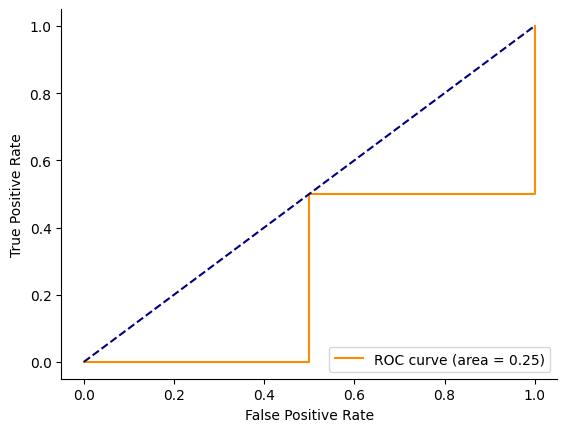

In [11]:
class_weights = util.get_class_weights(torch.tensor(test_y_bin.values).view(-1))
model, train_scores, test_scores, train_dataset, test_dataset = Pnet.run(genetic_data,
                                                                         test_y_bin,
                                                                         verbose=True,
                                                                         early_stopping=True,
                                                                         epochs=10,
                                                                         batch_size=10,
                                                                         loss_weight=class_weights,
                                                                         loss_fn=nn.BCEWithLogitsLoss(reduce=None),
                                                                         gene_set = canc_genes
                                                                        )

x_train = train_dataset.x
additional_train = train_dataset.additional
y_train = train_dataset.y
x_test = test_dataset.x
additional_test = test_dataset.additional
y_test = test_dataset.y

model.to('cpu')
pred, preds = model(x_test, additional_test)
y_pred_proba = model.predict_proba(x_test, additional_test).detach()

# Check if we have both classes in test set before calculating ROC AUC
unique_classes = torch.unique(y_test)
if len(unique_classes) < 2:
    print(f"Warning: Only {len(unique_classes)} class(es) in test set. ROC AUC cannot be calculated.")
    print(f"Test set labels: {y_test.flatten().tolist()}")
    test_auc = 0.5  # Default AUC for single class
else:
    fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
    test_auc = metrics.roc_auc_score(y_test, y_pred_proba)
    #create ROC curve
    plt.plot(fpr,tpr, color="darkorange", label="ROC curve (area = %0.2f)" % test_auc)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.legend(loc="lower right")
    plt.show()

In [12]:
model

PNET_NN(
  (loss_fn): BCEWithLogitsLoss()
  (layers): ModuleList(
    (0): PNET_Block(
      (gene_layer): Sequential(
        (0): CustomizedLinear(input_features=500, output_features=845, bias=True)
        (1): BatchNorm1d(845, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Tanh()
      )
      (pathway_layer): Sequential(
        (0): CustomizedLinear(input_features=734, output_features=845, bias=True)
        (1): BatchNorm1d(845, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Tanh()
        (3): Dropout(p=0.2, inplace=False)
      )
    )
    (1): PNET_Block(
      (gene_layer): Sequential(
        (0): CustomizedLinear(input_features=500, output_features=449, bias=True)
        (1): BatchNorm1d(449, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Tanh()
      )
      (pathway_layer): Sequential(
        (0): CustomizedLinear(input_features=845, output_features=449, bias=True)
        (1): Ba

In [13]:
class_weights = util.get_class_weights(torch.tensor(test_y_bin.values).view(-1))
model, train_scores, test_scores, train_dataset, test_dataset = Pnet.run_geneset(genetic_data,
                                                                         test_y_bin,
                                                                        geneset_path='/mnt/disks/pancan/pnet/data/hallmark/c6.all.v2022.1.Hs.symbols.gmt',
                                                                         verbose=True,
                                                                         early_stopping=True,
                                                                         epochs=10,
                                                                         batch_size=10,
                                                                         loss_weight=class_weights,
                                                                         loss_fn=nn.BCEWithLogitsLoss(reduce=None),
                                                                         genes = canc_genes
                                                                        )

x_train = train_dataset.x
additional_train = train_dataset.additional
y_train = train_dataset.y
x_test = test_dataset.x
additional_test = test_dataset.additional
y_test = test_dataset.y

model.to('cpu')
pred, preds = model(x_test, additional_test)
y_pred_proba = model.predict_proba(x_test, additional_test).detach()

# Check if we have both classes in test set before calculating ROC AUC
unique_classes = torch.unique(y_test)
if len(unique_classes) < 2:
    print(f"Warning: Only {len(unique_classes)} class(es) in test set. ROC AUC cannot be calculated.")
    print(f"Test set labels: {y_test.flatten().tolist()}")
    test_auc = 0.5  # Default AUC for single class
else:
    fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
    test_auc = metrics.roc_auc_score(y_test, y_pred_proba)
    #create ROC curve
    plt.plot(fpr,tpr, color="darkorange", label="ROC curve (area = %0.2f)" % test_auc)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.legend(loc="lower right")
    plt.show()

Task defined: BC 
 if this is not the intended task please specify task
Given 2 Input modalities
Found 20 overlapping indicies
Initializing Train Dataset
Found 500 overlapping genes
generated input DataFrame of size (16, 1000)
Initializing Test Dataset
Found 500 overlapping genes
generated input DataFrame of size (4, 1000)
Found 500 overlapping genes


FileNotFoundError: [Errno 2] No such file or directory: '/mnt/disks/pancan/pnet/data/hallmark/c6.all.v2022.1.Hs.symbols.gmt'

In [ ]:
model

In [ ]:
import GenesetNetwork
gn = GenesetNetwork.GenesetNetwork(canc_genes, '/mnt/disks/pancan/pnet/data/hallmark/c6.all.v2022.1.Hs.symbols.gmt')

In [ ]:
gn.pathway_encoding['ID'].nunique()

In [ ]:
[l.shape for l in gn.gene_layers]

In [ ]:
[l.shape for l in gn.pathway_layers]

In [ ]:
gn.is_no_bugs()

In [ ]:
gn.pathway_layers[0]

In [ ]:
gn.genes2pathways[gn.genes2pathways['gene'] == 'CCND2']

In [ ]:
gn.genes2pathways.index.value_counts()

In [ ]:
gn.genes2pathways['gene']

In [ ]:
pd.get_dummies(gn.genes2pathways['gene']).join(gn.genes2pathways['pathway']).groupby('pathway').sum().T

In [ ]:
df = pd.DataFrame(index=['train_loss', 'test_loss'], data=[train_scores, test_scores]).transpose()
df['auc'] = 0.75

In [ ]:
df

In [ ]:
task = util.get_task(test_y_bin)
target = util.format_target(test_y_bin, task)
train_dataset, test_dataset = pnet_loader.generate_train_test(genetic_data, target)
reactome_network = ReactomeNetwork.ReactomeNetwork(train_dataset.get_genes())

In [ ]:
model = Pnet.PNET_NN(reactome_network=reactome_network, task=task, nbr_gene_inputs=len(genetic_data),
                     loss_weight=class_weights, loss_fn=nn.BCEWithLogitsLoss(reduce=False))
train_loader, test_loader = pnet_loader.to_dataloader(train_dataset, test_dataset, 10)
model, train_scores, test_scores = Pnet.train(model, train_loader, test_loader, save_path='../results/model', epochs=10)

In [ ]:
def deeppathwayVAE_mask(gene_list, n_level=5):
    network = ReactomeNetworkOG.ReactomeNetwork(gene_list, n_levels=n_level)
    return network

In [ ]:
ReactomeNetwork = deeppathwayVAE_mask(gene_list, n_level=5)

In [ ]:
ReactomeNetwork.masks[-2].shape

In [ ]:
model.reactome_network.pathway_layers[0].shape

In [ ]:
# Already defined canc_genes above, but if needed again:
# canc_genes = gene_list
print(f"Cancer genes already loaded: {len(canc_genes)} genes")